In [1]:
%matplotlib inline
import ipywidgets
from jupyter_rs_radia import radia_viewer

import radia as rad
import radiamodels.ivu as ri
import radiamodels.util as ru
from ivu18_defaults import ivu18args

import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os.path
import copy

/nsls2/software/ap/python/3.9.1/lib/python3.9/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


ModuleNotFoundError: No module named 'radiamodels'

In [2]:
# define radia viewer
rv = radia_viewer.RadiaViewer()

In [19]:
# Copy ivu args
myivu18args = copy.copy(ivu18args)

# Conversion factors
TMM2GCM = 1e3

# default is just variable name unless name added/defined
name = None


myivu18args.update({
    'nhalfperiods': 3,
    'pole_chamfer_longedge': 0.3,
    'pole_chamfer_shortedge': 5.0,
    'pole_body_divisions': [6, [7, 5], 4],
    'pole_tip_divisions': [5, [8, 6], 7],

    'magnet_chamfer_gapside': 0.3,
    'magnet_chamfer_outerside': 0.5,
    'magnet_chamfer_outerside': 0.5,
    'magnet_divisions': [3, 5, 5],

})
if False:
    myivu18args.update({
        'pole_body_divisions': [1, 1, 1],
        'pole_tip_divisions': [1, 1, 1],
        'magnet_divisions': [1, 1, 1],
    })

undulator = ri.get_ivu(**myivu18args)


In [20]:
myivu18args

{'gap': 4.63,
 'taper': 0,
 'tilt': 0,
 'period': 18,
 'nhalfperiods': 3,
 'half_pole_size': [19.0, 21.5, 2.8],
 'pole_material': 3,
 'pole_body_divisions': [6, [7, 5], 4],
 'pole_tip_divisions': [5, [8, 6], 7],
 'pole_chamfer_shortedge': 5.0,
 'pole_chamfer_longedge': 0.3,
 'pole_tip_height': 5,
 'pole_offset_y': 0,
 'quartermagnet_size_xy': [29.0, 30],
 'magnet_material': 4,
 'magnet_divisions': [3, 5, 5],
 'magnet_chamfer_corner': 1,
 'magnet_chamfer_outerside': 0.5,
 'magnet_chamfer_gapside': 0.3,
 'magnet_chamfer_farside': 0,
 'magnet_offset_y': 0,
 'air_gap': 0.05,
 'end1_pole_height': 15,
 'end1_magnet_height': 20,
 'end2_pole_height': 6,
 'end2_magnet_height': 9,
 'girder_top_roll_rad': 0,
 'girder_bot_roll_rad': 0,
 'returnobject': 0,
 'debug': False}

In [21]:
rv.add_geometry('und', undulator)
rv.display()

RadiaViewer(children=(Viewer(children=(VTK(layout=Layout(margin='auto', min_width='25%', width='50%'), model_d…

In [5]:
rad.Solve(undulator, 0.0003, 2000)

Warning: The specified accuracy was not reached. This may indicate diverging or incomplete relaxation.

[0.014664248037801347, 2.297890672882042, 1.4032459557183992, 2000.0]

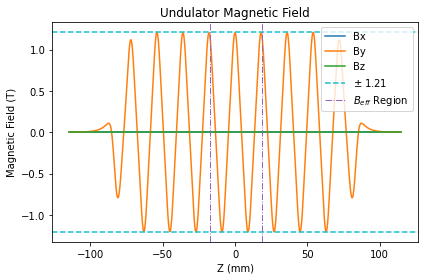

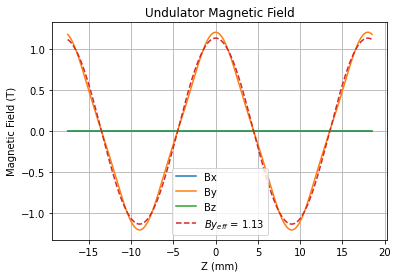

Keff 1.902795545869103


In [7]:
PERIOD = ivu18args['period']
NHALFPERIODS = ivu18args['nhalfperiods']

# Full undulator
Z = np.linspace(-1.7*PERIOD*NHALFPERIODS/4, 1.7*PERIOD*NHALFPERIODS/4, 1001)
B = [rad.Fld(undulator, 'b', [0, 0, z]) for z in Z]

# Just part to take effective field from
zstart = -PERIOD + PERIOD * NHALFPERIODS%4/4
zstop = zstart + 2 * PERIOD

# Show full field and where effective field is taken from
plt.figure()
plt.title(f'Undulator Magnetic Field')
plt.xlabel('Z (mm)')
plt.ylabel('Magnetic Field (T)')
plt.plot(Z, [b[0] for b in B], label='Bx')
plt.plot(Z, [b[1] for b in B], label='By')
plt.plot(Z, [b[2] for b in B], label='Bz')
mymax=[max([np.abs(b[i]) for b in B]) for i in range(3)]
plt.axhline(+mymax[1], linestyle='--', color='tab:cyan', label=f'$\\pm$ {round(mymax[1], 2)}')
plt.axhline(-mymax[1], linestyle='--', color='tab:cyan')
plt.axvline(zstart, color='tab:purple', linestyle='-.', linewidth=1, label='$B_{eff}$ Region')
plt.axvline(zstop, color='tab:purple', linestyle='-.', linewidth=1)
plt.legend()
plt.tight_layout()
plt.show()

Z2P = np.linspace(zstart, zstop, 5001)
B2P = [rad.Fld(undulator, 'b', [0, 0, z]) for z in Z2P]
ByEffMag = ru.get_beff(Z2P, [b[1] for b in B2P], 2)
ByEff = [-ByEffMag*np.sin(2*np.pi/PERIOD * z + 2*np.pi*(NHALFPERIODS%4/4)) for z in Z2P]
plt.figure()
plt.title(f'Undulator Magnetic Field')
plt.xlabel('Z (mm)')
plt.ylabel('Magnetic Field (T)')
plt.plot(Z2P, [b[0] for b in B2P], label='Bx')
plt.plot(Z2P, [b[1] for b in B2P], label='By')
plt.plot(Z2P, [b[2] for b in B2P], label='Bz')
plt.plot(Z2P, ByEff, '--', label='$By_{eff}$ = ' + f'{round(ByEffMag, 2)}')
plt.legend()
plt.grid()
plt.show()

print('Keff', 0.09336*ByEffMag*PERIOD)

In [31]:
epsilon_y = 30e-12
beta0_y = 1.1

L = 3/2
GAP = 5e-3

beta_y = beta0_y + L**2 / beta0_y
sigma_y = np.sqrt(epsilon_y * beta_y)

nsigma = GAP/sigma_y
print(f'sigma_y {sigma_y}, nsigma {nsigma}')

sigma_y 9.714094726923161e-06, nsigma 514.71600190826


In [30]:
L = 2.4/2

beta_y = beta0_y + L**2 / beta0_y
sigma_y = np.sqrt(epsilon_y * beta_y)

minaper = nsigma * sigma_y
print(f'sigma_y {sigma_y}, minaper {minaper}')

sigma_y 4.390071442781686e-06, minaper 0.004375774085111186
